## Dynamic flux based analysis


dFBA is used to simulate the fermenation processes using our strain.

Here we try to maximize psilocybin production, and visualize the psilocybin production over time, with glucose as the carbon source.

#### Introductory stuff - import of various libraries needed for DFBA and the model

In [1]:
%run Medium_significance.ipynb

from dfba import DfbaModel, ExchangeFlux, KineticVariable
from dfba.plot.matplotlib import *

'' is not a valid SBML 'SId'.


Maximum theoretical biomass productivity: 0.9398547241492603 mmol/(gdw*h)
Maximum theoretical productivity of psilocybin_synthase reaction: 3.0787126793330786 mmol/(gdw*h)
Maximum theoretical biomass productivity: 15.675217280226356 mmol/(gdw*h)
Maximum theoretical productivity of psilocybin_synthase reaction: 57.96313293559737 mmol/(gdw*h
0.0
52.65029830197339
0.0
54.31925959920456
0.0
52.497322931008114
0.0
53.40829126510632
0.0
50.67538626281172
0.0
52.42312987608998
0.0
52.497322931008114
0.0
52.193666819642075


The numbers printed above this, is from Medium_significane.ipynb, and can be ignored.

Defining the model objective to optimize the psilosybin synthase along with optimization of the model 

In [2]:
model.objective = model.reactions.psiM
model.optimize();

### DFBA starts here

The solver is set to glpk

In [3]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

The apparent important metabolites for psilosybin production are added to the model as kinetic variables.

In [4]:
X = KineticVariable("Biomass")
Glc = KineticVariable("Glucose")
Psi = KineticVariable("Psilocybin")
Oxy = KineticVariable("Oxygen")

dfba_model.add_kinetic_variables([X, Glc, Psi, Oxy])

Adding the exchange fluxes to appear the model using the reaction ID's

In [5]:
mu = ExchangeFlux("DRAIN_Biomass")
v_G = ExchangeFlux("BOUNDARY_GLCe")
v_Psi = ExchangeFlux("psiM")
v_O = ExchangeFlux("BOUNDARY_O2e")

dfba_model.add_exchange_fluxes([mu, v_G, v_Psi, v_O])

Adding the right hand expressions for calculating the time derivative of each kinetic variable.

In [6]:
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X)
dfba_model.add_rhs_expression("Psilocybin", v_Psi * 284.25/1000.0 * X)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant

Adding expressions for calculating lower/upper bounds of the selected exchange fluxes. 

In [7]:
dfba_model.add_exchange_flux_lb("BOUNDARY_GLCe", 2.5 * (Glc / (0.0027 + Glc)), Glc)
dfba_model.add_exchange_flux_lb("BOUNDARY_O2e", 15.0 * (Oxy / (0.024 + Oxy)), Oxy)
dfba_model.add_exchange_flux_lb("psiM", 0.7 * (Psi / (0.3 + Psi)), Psi)       #Guesstimates based on trp

Adding initial conditions. Biomass is set high and kept constant, as psilocyibin is set as the objective -> all glucose will be used for converstion to psilocybin.

In [8]:
with model:
    dfba_model.add_initial_conditions({"Biomass": 1, "Glucose": 20.0, "Psilocybin": 0.0, "Oxygen": 39})
    concentrations, trajectories = dfba_model.simulate(0.0, 1000.0, 0.1, ["BOUNDARY_GLCe", "psiM"])

Plotting the concentrations and tradjectories.

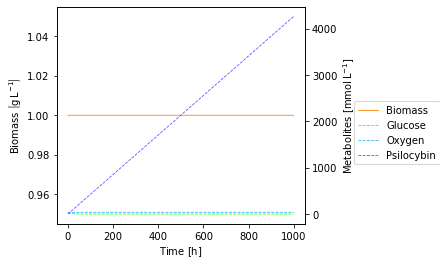

In [9]:
plot_concentrations(concentrations)

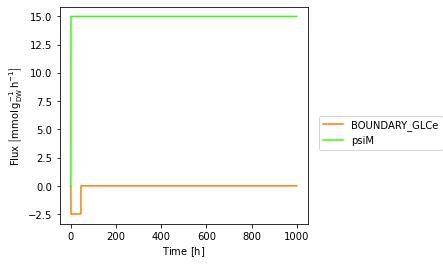

In [10]:
plot_trajectories(trajectories)

As the reader may notice, the above plots doesn't give the full picture as trp, the precurser to psilocybin, is not in the picture. Therefore, new caluclations will be performed adding trp to the model.

In [11]:
Trp = KineticVariable("Tryptophan")
dfba_model.add_kinetic_variables([Trp])

v_Trp = ExchangeFlux("r385")
dfba_model.add_exchange_fluxes([v_Trp])

dfba_model.add_rhs_expression("Tryptophan", v_Trp * 204.22/1000.0 * X)

dfba_model.add_exchange_flux_lb("r385", 0.7 * (Trp / (0.3 + Trp)), Trp)

Setting the initial conditions while including trp

In [12]:
with model:
    dfba_model.add_initial_conditions({"Biomass": 1, "Tryptophan": 0.1, "Glucose": 20.0, "Psilocybin": 0.0, "Oxygen": 39})
    concentrations, trajectories = dfba_model.simulate(0.0, 100.0, 0.5, ["BOUNDARY_GLCe", "r385", "psiM"])

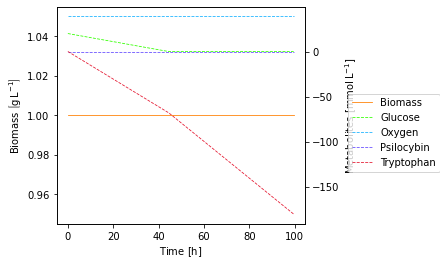

In [13]:
plot_concentrations(concentrations)

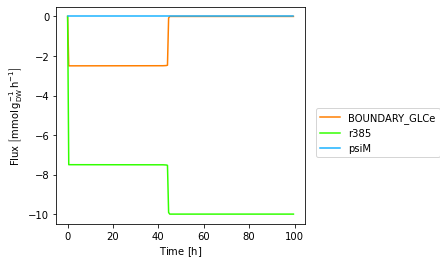

In [14]:
plot_trajectories(trajectories)

As seen from the plot, no trp is converted to psilocybin. Therefore, we tried to increase the simulation time and the glucose concentration, to see how, this would affect the simulation.

In [15]:
with model:
    dfba_model.add_initial_conditions({"Biomass": 1, "Tryptophan": 0.1, "Glucose": 200.0, "Psilocybin": 0.0,"Oxygen": 39})
    concentrations, trajectories = dfba_model.simulate(0.0, 1000.0, 0.5, ["BOUNDARY_GLCe", "r385", "psiM"])

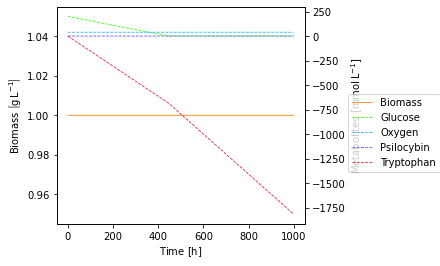

In [16]:
plot_concentrations(concentrations)

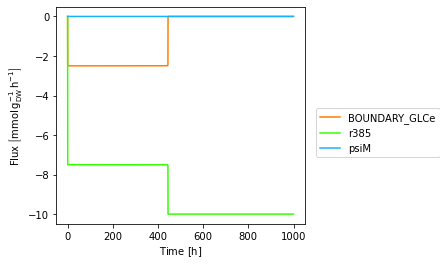

In [17]:
plot_trajectories(trajectories)

As nothing was changed, except the glucosce concentration and runtime, no changes was expected in the plot. However, to try and fix this, we set the lower bounds of psiM to be high and therefore, try to push the flux towards psilocybin production.

In [18]:
model.reactions.psiM.lower_bounds = -1000
model.optimize();

In [19]:
with model:
    dfba_model.add_initial_conditions({"Biomass": 1, "Tryptophan": 0.1, "Glucose": 20.0, "Psilocybin": 0.0, "Oxygen": 39})
    concentrations, trajectories = dfba_model.simulate(0.0, 200.0, 0.5, ["BOUNDARY_GLCe", "r385", "psiM"])

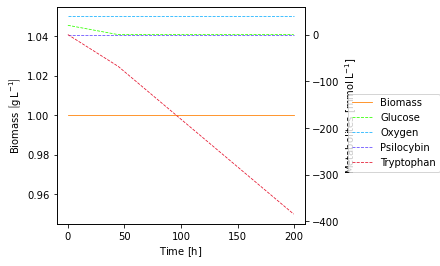

In [20]:
plot_concentrations(concentrations)

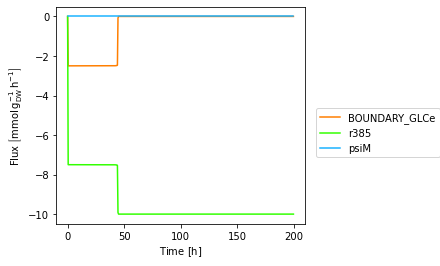

In [21]:
plot_trajectories(trajectories)

As seen from the plot above no psilocybin is produced. This may be because reaction flux is not forced through the psilocybin pathway.

As another option, loopless FBA has been carried out instead. A look occurs, as a spontaneous dephosphorylation/phosphatase mediated phosporylation converts psilocybin to psilocin, which is then converted back to psilocybin by psiK - the 4-hydroxytryptamine kinase.